<a href="https://colab.research.google.com/github/JoshKonoff/EfficientNet_vs_ResNet_fiirst_draft/blob/main/Transfer_Learning_EfficientNet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jul 27 02:31:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Get data
import zipfile

#Download the data
!wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [3]:
# How many images in each folder?
import os

#Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 10 director

In [4]:
#There are less training images (only 75) but the same amount of test images

In [5]:
#Load and then prep the data

#We'll use the ImageDataGenerator class to load in our images in batches

In [6]:
#Import ImageDataGenertor

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
### Set up the Image_shape and Bathch_Size global variables for multiples uses later

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.) #to normalize the data in a moment
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing images: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


In [8]:
#We have 10X less training data to find patterns on :(
#How can we use transfer learning to get exceptional results anyway?

In [9]:
#Setting up callbacks (things to run whilst our model trains)

#Callback are extra functionality you can add to your models

#1. Tracking experiments with TensorBoart callback

#2. Model checkpointing - with the ModelCheckpoint callbacks - save your model as it trains - helpful when you can't train everything in one sitting

#3. Early stopping - Stopping a model from training (before it trains too long and overfits).
#Your model will cease to trian when it stops improviding

In [29]:
# Create TensorBoard callback - (let's functionize it so that we can create a new one for each model)

import datetime #b/c we're going to use a timestamp for when our model was run
#ex: we ran our model last Wednesday

#experiment name - say we wnat model_3 as our experiement 0- we could set it as our experiement

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )

  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorboard_callback

In [11]:
#In the past we created our own models layer by layer from sratch

###Now we're use TensorFlow Hub and paperswithcode.com to grab powerful pre-made models
#such as EfficientNet and resnet

In [12]:
#Let's compare the following two models

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [13]:
#We're working on image classification - so let's look for an efficientnet model trained for images
#TF Hub makes using a pre-trained model as simple as calling a URL

In [14]:
#Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [15]:
#In the past we created a ton of functions form scratch - let's start to functionize it
#Let's make a create_model() function to create a model from a URL
#What will we need? We'll need a model_url, num_classes - how many classes are we working with

def create_model(model_url, num_classes=10):
  '''Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TF Hub feature extraction URL.
  num_classes(int): Number of output neurons in the outlayer,
  should be equal to number of target classes, default 10.

  Returns:
  An uncopiled Keras Sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output neurons
  '''

  #Download the pretrained model and save it as a Keras layer
  #On TF hub all the models have example usage
  #freeze the already learned patterns - these model have laready ben trained on ImageNet
  #give it a name so that we know what it is
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE +(3,)) ### Image_shape + color channels

  #Create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation='softmax', name='output_layer')
                              
  ])

  return model


In [16]:
### Our above model is only ~5 lines of code

In [17]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [19]:
#Create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes) ####train_data_10_percent.num_classes - we could have just left it as 10

In [20]:
train_data_10_percent.num_classes

10

In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
#Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [23]:
###Blowing our previous models out of the water with our first transfer learning model!
#We just compiled, so now let's fit!

In [30]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20210727-024759
Epoch 1/5
24/24 [==============================] - 34s 720ms/step - loss: 1.8648 - accuracy: 0.3640 - val_loss: 1.1560 - val_accuracy: 0.6516
Epoch 2/5
24/24 [==============================] - 14s 607ms/step - loss: 0.8658 - accuracy: 0.7533 - val_loss: 0.8433 - val_accuracy: 0.7344
Epoch 3/5
24/24 [==============================] - 14s 614ms/step - loss: 0.5910 - accuracy: 0.8373 - val_loss: 0.7605 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 14s 614ms/step - loss: 0.4598 - accuracy: 0.8720 - val_loss: 0.7169 - val_accuracy: 0.7644
Epoch 5/5
24/24 [==============================] - 15s 648ms/step - loss: 0.3651 - accuracy: 0.9133 - val_loss: 0.6811 - val_accuracy: 0.7708


In [31]:
#Wow!
#This is incredible. This model killed all of the previous models we built by hand
#and in less time and with only 10% of the training examples!

In [33]:
#Let's create a function to plot our loss curves
#Let's also put this in a helper.py

In [34]:
import matplotlib.pyplot as plt

#Plot the validation and training curves
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics.

  Args:
  history: TensorFlow History object.

  Returns:
  Plots of training/validation loss and accuracy.
  '''

  loss= history.history['loss']
  val_loss=history.history['val_loss']

  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='train_accuracy') #Pass in the number of epochs, accuracy, and a label
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

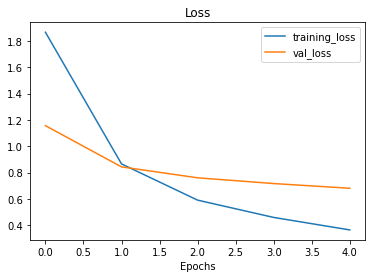

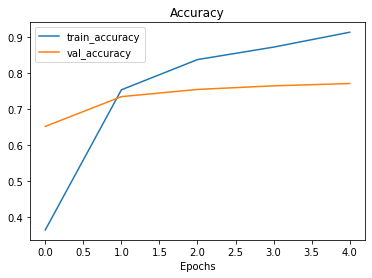

In [35]:
plot_loss_curves(resnet_history)

In [36]:
### Compare resnet vs efficientnet
#So now let's create and test EfficientNetB0 TF Hub Feature extraction model

In [42]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to tensorflow_hub/efficientnetB0/20210727-031655

Got `type(handle)`: <class 'tensorflow.python.keras.engine.sequential.Sequential'>



Got `type(handle)`: <class 'tensorflow.python.keras.engine.sequential.Sequential'>


Epoch 1/5
24/24 [==============================] - 28s 1s/step - loss: 2.3071 - accuracy: 0.1000 - val_loss: 2.3064 - val_accuracy: 0.1000
Epoch 2/5
24/24 [==============================] - 15s 636ms/step - loss: 2.3061 - accuracy: 0.1000 - val_loss: 2.3057 - val_accuracy: 0.1000
Epoch 3/5
24/24 [==============================] - 14s 612ms/step - loss: 2.3056 - accuracy: 0.1000 - val_loss: 2.3052 - val_accuracy: 0.1000
Epoch 4/5
24/24 [==============================] - 15s 634ms/step - loss: 2.3052 - accuracy: 0.1000 - val_loss: 2.3048 - val_accuracy: 0.1000
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 2.3046 - accuracy: 0.1000 - val_loss: 2.3044 - val_accuracy: 0.1000


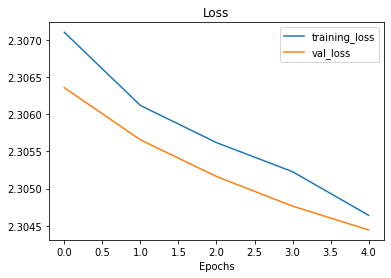

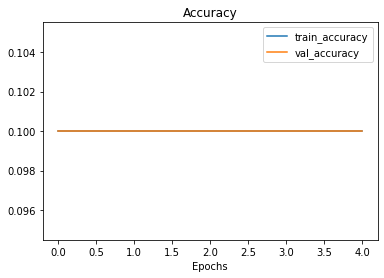

In [45]:
plot_loss_curves(efficientnet_history)

In [52]:
#How many layers does our efficientnetb0 feature extractor have?

len(efficientnet_model.layers[0].weights)

313

In [53]:
#The previous hand-made architecture was only 6 layers!

In [54]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-07-27 03:22:55.611142: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [56]:
#Tensorboard.dev to compare EfficientNet vs ResNet